### 사이킷런 Wrapper XGBoost 개요 및 적용 
Boosting 이란?
- 여러 개의 약한 의사결정나무(Decision Tree)를 조합해서 사용하는 앙상블(Ensemble) 기법 중 하나
즉, 약한 예측 모형들의 학습 에러에 가중치를 두고, 순차적으로 다음 학습 모델에 반영하여 강한 예측모형을 만든다.

XGBoost 란?
- XGBoost는 Extreme Gradient Boosting의 약자이다. 해석하면 극한 변화도(경사도) 부스팅
- Boosting 기법을 이용하여 구현한 알고리즘은 Gradient Boost 가 대표적
- 이 알고리즘을 병렬 학습이 지원되도록 구현한 라이브러리가 XGBoost 이다.
- Regression, Classification 문제를 모두 지원하며, 성능과 자원 효율이 좋아서, 인기 있게 사용되는 알고리즘 이다.

XGBoost의 장점
- GBM 대비 빠른 수행시간
- 병렬 처리로 학습, 분류 속도가 빠르다.
- 과적합 규제(Regularization)
- 표준 GBM 경우 과적합 규제기능이 없으나, XGBoost는 자체에 과적합 규제 기능으로 강한 내구성 지닌다.
- 분류와 회귀영역에서 뛰어난 예측 성능 발휘
- 즉, CART(Classification and regression tree) 앙상블 모델을 사용
- Early Stopping(조기 종료) 기능이 있음
- 다양한 옵션을 제공하며 Customizing이 용이하다.
- Missing Values : 결측치를 내부적으로 처리해준다. 실제로 kaggle에 적용해보는 과정에서 편리함


#### 사이킷런 래퍼 XGBoost 적용 - 위스콘신 유방암 예측

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [6]:
print(dataset.target_names)
cancer_df.target.value_counts()
# malignant : 악성 (0) | benign : 양성 (1)

['malignant' 'benign']


1    357
0    212
Name: target, dtype: int64

In [3]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test , pred, pred_proba):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [9]:
!pip install xgboost

     ------------------------------------ 125.4/125.4 MB 916.8 kB/s eta 0:00:00

[notice] A new release of pip available: 22.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
from xgboost import XGBClassifier
evals = [(X_test,y_test)]
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=400, eval_set=evals, eval_metric='logloss', verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_preds_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08620
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08645
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

In [21]:
get_clf_eval(y_test, w_preds, w_preds_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


In [24]:
# early_stopping_rounds = 100
# 100번 연속 개선이 안되면 멈춰라
# 211번에서 311번 까지 반복동안 성능 평가 지수가 향상되지 않으므로 stop

from xgboost import XGBClassifier
evals = [(X_test,y_test)]
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_set=evals, eval_metric='logloss', verbose=True)
w100_preds = xgb_wrapper.predict(X_test)
w100_preds_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08620
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08645
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

In [25]:
get_clf_eval(y_test, w100_preds, w100_preds_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

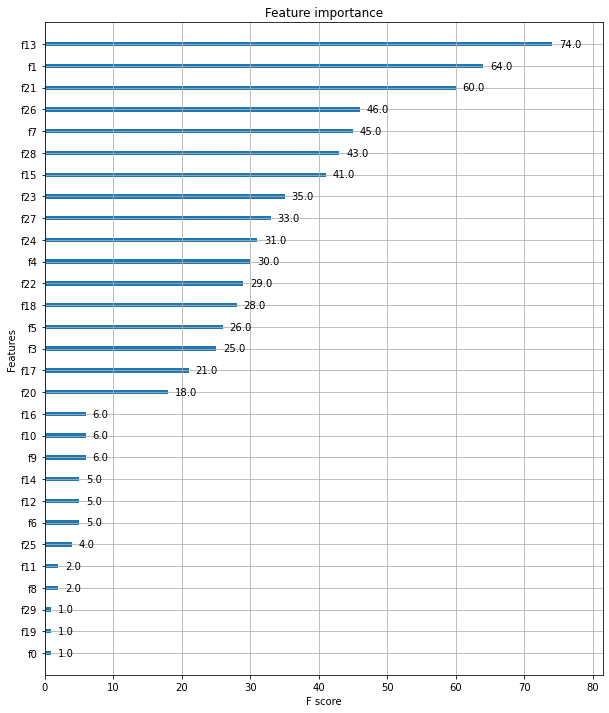

In [26]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_wrapper,ax=ax)

In [27]:
!pip install lightgbm

     ---------------------------------------- 1.0/1.0 MB 5.9 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


#### 과제_0921_3

LightGBM을 이용하여 위스콘신 유방암 모델 생성하고 평가 및 변수 중요도를 시각화하세요.

In [29]:
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target'] = dataset.target
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train,y_train,test_size=0.1, random_state=156)

lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# LightBGM도 조기 중단 수행 가능
evals = [(X_tr,y_tr),(X_val, y_val)]
lgbm_wrapper.fit(X_tr,y_tr,early_stopping_rounds=50, eval_metric='logloss', eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

In [30]:
get_clf_eval(y_test,preds,pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9877


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

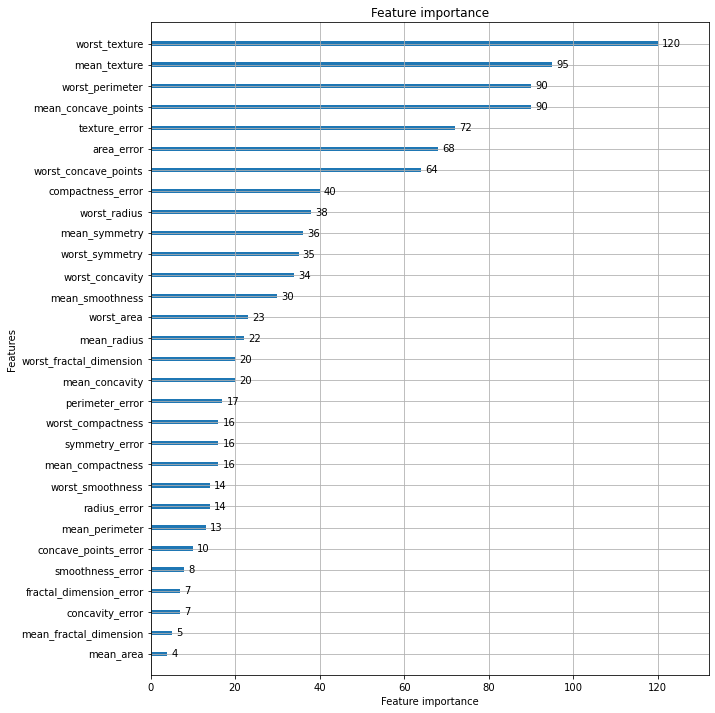

In [32]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper,ax=ax)

#### [도전과제]
캐글 산탄데르 고객 만족 예측 분석을 수행하세요.(p267 ~)
https://www.kaggle.com/competitions/santander-customer-satisfaction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv('train_santander.csv', encoding='latin-1')
print(cust_df.shape)
cust_df.head()

(76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [3]:
print(cust_df.TARGET.value_counts())
unsatisfied_cnt = cust_df[cust_df.TARGET==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print(f'unsatisfied 비율은 {unsatisfied_cnt / total_cnt:.2f}')

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [4]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [5]:
cust_df.var3.value_counts()[:10]

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64

In [6]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df.var3.replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

X_features = cust_df.iloc[:,:-1]
y_labels = cust_df.iloc[:,-1]
X_features.shape

(76020, 369)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 데이터 : \n',y_train.value_counts()/train_cnt,'\n')
print('테스트 데이터 : \n',y_test.value_counts()/test_cnt)

학습 데이터 : 
 0    0.960964
1    0.039036
Name: TARGET, dtype: float64 

테스트 데이터 : 
 0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [12]:
# lightGBM 학습
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

lgbm_clf = LGBMClassifier(n_estimators=500)
evals = [(X_test,y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals, verbose=False)
lgbm_roc_score = roc_auc_score(y_test,lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print(f'ROC AUC : {lgbm_roc_score:.4f}')

ROC AUC : 0.8409


In [13]:
from sklearn.model_selection import GridSearchCV

lgbm_clf = LGBMClassifier(n_estimator=200)

params = {'num_leaves': [32, 64 ],
          'max_depth':[128, 160],
          'min_child_samples':[60, 100],
          'subsample':[0.8, 1]}
gridcv = GridSearchCV(lgbm_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(X_train, y_train)])
print(f'최적 하이퍼 파라미터 : {gridcv.best_params_}')
lgbm_roc_score = roc_auc_score(y_test,gridcv.predict_proba(X_test)[:,1], average='macro')
print(f'ROC AUC : {lgbm_roc_score:.4f}')

[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.823664	valid_0's binary_logloss: 0.156198
[2]	valid_0's auc: 0.82966	valid_0's binary_logloss: 0.150925
[3]	valid_0's auc: 0.834498	valid_0's binary_logloss: 0.147158
[4]	valid_0's auc: 0.83904	valid_0's binary_logloss: 0.144173
[5]	valid_0's auc: 0.841964	valid_0's binary_logloss: 0.141745
[6]	valid_0's auc: 0.845253	valid_0's binary_logloss: 0.139712
[7]	valid_0's auc: 0.846545	valid_0's binary_logloss: 0.138053
[8]	valid_0's auc: 0.848885	valid_0's binary_logloss: 0.1366
[9]	valid_0's auc: 0.850839	valid_0's binary_logloss: 0.135205
[10]	valid_0's auc: 0.851902	valid_0's binary_logloss: 0.134136
[11]	valid_0's auc: 0.853188	valid_0's binary_logloss: 0.133195
[12]	valid_0's auc: 0.856101	valid_0's binary_logloss: 0.13225
[13]	valid_0's auc: 0.857693	valid_0's binary_logloss: 0.131411
[14]	valid_0's auc: 0.859427	valid_0's binary_logloss: 0.130627
[15]	valid_0's auc: 0.861064	valid_0's binary_logloss: 0.12997
[16

[49]	valid_0's auc: 0.890008	valid_0's binary_logloss: 0.119059
[50]	valid_0's auc: 0.890402	valid_0's binary_logloss: 0.118864
[51]	valid_0's auc: 0.891509	valid_0's binary_logloss: 0.118592
[52]	valid_0's auc: 0.891996	valid_0's binary_logloss: 0.118382
[53]	valid_0's auc: 0.892433	valid_0's binary_logloss: 0.118243
[54]	valid_0's auc: 0.893021	valid_0's binary_logloss: 0.117998
[55]	valid_0's auc: 0.893762	valid_0's binary_logloss: 0.117749
[56]	valid_0's auc: 0.894146	valid_0's binary_logloss: 0.117569
[57]	valid_0's auc: 0.894522	valid_0's binary_logloss: 0.1174
[58]	valid_0's auc: 0.894783	valid_0's binary_logloss: 0.117263
[59]	valid_0's auc: 0.895158	valid_0's binary_logloss: 0.11709
[60]	valid_0's auc: 0.895424	valid_0's binary_logloss: 0.116944
[61]	valid_0's auc: 0.895945	valid_0's binary_logloss: 0.116729
[62]	valid_0's auc: 0.896352	valid_0's binary_logloss: 0.116521
[63]	valid_0's auc: 0.896635	valid_0's binary_logloss: 0.116361
[64]	valid_0's auc: 0.89699	valid_0's binar

[90]	valid_0's auc: 0.903802	valid_0's binary_logloss: 0.112409
[91]	valid_0's auc: 0.904198	valid_0's binary_logloss: 0.112209
[92]	valid_0's auc: 0.90455	valid_0's binary_logloss: 0.112054
[93]	valid_0's auc: 0.90518	valid_0's binary_logloss: 0.111831
[94]	valid_0's auc: 0.90538	valid_0's binary_logloss: 0.111738
[95]	valid_0's auc: 0.905521	valid_0's binary_logloss: 0.111631
[96]	valid_0's auc: 0.905687	valid_0's binary_logloss: 0.111512
[97]	valid_0's auc: 0.906028	valid_0's binary_logloss: 0.111348
[98]	valid_0's auc: 0.90653	valid_0's binary_logloss: 0.111173
[99]	valid_0's auc: 0.906948	valid_0's binary_logloss: 0.110993
[100]	valid_0's auc: 0.907114	valid_0's binary_logloss: 0.110885
[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.823084	valid_0's binary_logloss: 0.156066
[2]	valid_0's auc: 0.827813	valid_0's binary_logloss: 0.150805
[3]	valid_0's auc: 0.836023	valid_0's binary_logloss: 0.147035
[4]	valid_0's auc: 0.842374	valid_0's binary_logloss: 0.14

[20]	valid_0's auc: 0.86902	valid_0's binary_logloss: 0.126956
[21]	valid_0's auc: 0.869954	valid_0's binary_logloss: 0.126491
[22]	valid_0's auc: 0.870971	valid_0's binary_logloss: 0.126075
[23]	valid_0's auc: 0.872384	valid_0's binary_logloss: 0.125599
[24]	valid_0's auc: 0.873433	valid_0's binary_logloss: 0.125215
[25]	valid_0's auc: 0.874094	valid_0's binary_logloss: 0.124834
[26]	valid_0's auc: 0.875299	valid_0's binary_logloss: 0.12446
[27]	valid_0's auc: 0.875863	valid_0's binary_logloss: 0.124178
[28]	valid_0's auc: 0.876477	valid_0's binary_logloss: 0.123899
[29]	valid_0's auc: 0.877436	valid_0's binary_logloss: 0.123585
[30]	valid_0's auc: 0.878569	valid_0's binary_logloss: 0.123249
[31]	valid_0's auc: 0.879246	valid_0's binary_logloss: 0.122979
[32]	valid_0's auc: 0.880496	valid_0's binary_logloss: 0.122664
[33]	valid_0's auc: 0.881439	valid_0's binary_logloss: 0.122371
[34]	valid_0's auc: 0.882347	valid_0's binary_logloss: 0.122119
[35]	valid_0's auc: 0.883154	valid_0's bin

[71]	valid_0's auc: 0.899238	valid_0's binary_logloss: 0.115201
[72]	valid_0's auc: 0.899499	valid_0's binary_logloss: 0.115062
[73]	valid_0's auc: 0.900011	valid_0's binary_logloss: 0.114934
[74]	valid_0's auc: 0.900164	valid_0's binary_logloss: 0.114807
[75]	valid_0's auc: 0.900481	valid_0's binary_logloss: 0.114657
[76]	valid_0's auc: 0.900822	valid_0's binary_logloss: 0.114553
[77]	valid_0's auc: 0.90094	valid_0's binary_logloss: 0.114453
[78]	valid_0's auc: 0.901041	valid_0's binary_logloss: 0.114363
[79]	valid_0's auc: 0.901179	valid_0's binary_logloss: 0.114265
[80]	valid_0's auc: 0.901352	valid_0's binary_logloss: 0.114148
[81]	valid_0's auc: 0.901614	valid_0's binary_logloss: 0.114039
[82]	valid_0's auc: 0.901923	valid_0's binary_logloss: 0.113857
[83]	valid_0's auc: 0.90216	valid_0's binary_logloss: 0.113764
[84]	valid_0's auc: 0.902635	valid_0's binary_logloss: 0.113574
[85]	valid_0's auc: 0.90277	valid_0's binary_logloss: 0.113473
[86]	valid_0's auc: 0.903386	valid_0's bina

[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.825972	valid_0's binary_logloss: 0.15626
[2]	valid_0's auc: 0.830735	valid_0's binary_logloss: 0.150869
[3]	valid_0's auc: 0.836213	valid_0's binary_logloss: 0.147022
[4]	valid_0's auc: 0.839911	valid_0's binary_logloss: 0.143985
[5]	valid_0's auc: 0.842712	valid_0's binary_logloss: 0.14152
[6]	valid_0's auc: 0.84576	valid_0's binary_logloss: 0.139503
[7]	valid_0's auc: 0.84864	valid_0's binary_logloss: 0.137792
[8]	valid_0's auc: 0.850006	valid_0's binary_logloss: 0.136329
[9]	valid_0's auc: 0.852085	valid_0's binary_logloss: 0.135086
[10]	valid_0's auc: 0.854171	valid_0's binary_logloss: 0.133973
[11]	valid_0's auc: 0.856458	valid_0's binary_logloss: 0.132947
[12]	valid_0's auc: 0.857299	valid_0's binary_logloss: 0.132061
[13]	valid_0's auc: 0.858451	valid_0's binary_logloss: 0.131304
[14]	valid_0's auc: 0.860294	valid_0's binary_logloss: 0.130565
[15]	valid_0's auc: 0.861473	valid_0's binary_logloss: 0.129923
[

[49]	valid_0's auc: 0.888673	valid_0's binary_logloss: 0.119238
[50]	valid_0's auc: 0.889057	valid_0's binary_logloss: 0.119043
[51]	valid_0's auc: 0.889739	valid_0's binary_logloss: 0.118806
[52]	valid_0's auc: 0.890742	valid_0's binary_logloss: 0.118587
[53]	valid_0's auc: 0.891196	valid_0's binary_logloss: 0.11838
[54]	valid_0's auc: 0.891799	valid_0's binary_logloss: 0.11816
[55]	valid_0's auc: 0.89214	valid_0's binary_logloss: 0.118007
[56]	valid_0's auc: 0.892519	valid_0's binary_logloss: 0.117803
[57]	valid_0's auc: 0.89341	valid_0's binary_logloss: 0.11759
[58]	valid_0's auc: 0.89398	valid_0's binary_logloss: 0.117404
[59]	valid_0's auc: 0.894378	valid_0's binary_logloss: 0.117189
[60]	valid_0's auc: 0.894995	valid_0's binary_logloss: 0.116914
[61]	valid_0's auc: 0.895118	valid_0's binary_logloss: 0.116783
[62]	valid_0's auc: 0.89571	valid_0's binary_logloss: 0.116545
[63]	valid_0's auc: 0.895879	valid_0's binary_logloss: 0.116415
[64]	valid_0's auc: 0.89601	valid_0's binary_lo

[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.832025	valid_0's binary_logloss: 0.155465
[2]	valid_0's auc: 0.844878	valid_0's binary_logloss: 0.14969
[3]	valid_0's auc: 0.848608	valid_0's binary_logloss: 0.145495
[4]	valid_0's auc: 0.85412	valid_0's binary_logloss: 0.142244
[5]	valid_0's auc: 0.856985	valid_0's binary_logloss: 0.139541
[6]	valid_0's auc: 0.860318	valid_0's binary_logloss: 0.137315
[7]	valid_0's auc: 0.862354	valid_0's binary_logloss: 0.135314
[8]	valid_0's auc: 0.864507	valid_0's binary_logloss: 0.133588
[9]	valid_0's auc: 0.866506	valid_0's binary_logloss: 0.132094
[10]	valid_0's auc: 0.867622	valid_0's binary_logloss: 0.130807
[11]	valid_0's auc: 0.869595	valid_0's binary_logloss: 0.12963
[12]	valid_0's auc: 0.871732	valid_0's binary_logloss: 0.128488
[13]	valid_0's auc: 0.874689	valid_0's binary_logloss: 0.127457
[14]	valid_0's auc: 0.876111	valid_0's binary_logloss: 0.126511
[15]	valid_0's auc: 0.87877	valid_0's binary_logloss: 0.12553
[1

[37]	valid_0's auc: 0.90518	valid_0's binary_logloss: 0.113632
[38]	valid_0's auc: 0.905995	valid_0's binary_logloss: 0.113243
[39]	valid_0's auc: 0.906844	valid_0's binary_logloss: 0.112853
[40]	valid_0's auc: 0.907562	valid_0's binary_logloss: 0.112486
[41]	valid_0's auc: 0.908588	valid_0's binary_logloss: 0.112133
[42]	valid_0's auc: 0.909345	valid_0's binary_logloss: 0.111816
[43]	valid_0's auc: 0.910274	valid_0's binary_logloss: 0.111456
[44]	valid_0's auc: 0.910736	valid_0's binary_logloss: 0.111124
[45]	valid_0's auc: 0.911482	valid_0's binary_logloss: 0.110813
[46]	valid_0's auc: 0.911866	valid_0's binary_logloss: 0.110548
[47]	valid_0's auc: 0.912425	valid_0's binary_logloss: 0.110275
[48]	valid_0's auc: 0.912979	valid_0's binary_logloss: 0.109953
[49]	valid_0's auc: 0.913784	valid_0's binary_logloss: 0.10967
[50]	valid_0's auc: 0.914306	valid_0's binary_logloss: 0.109371
[51]	valid_0's auc: 0.914719	valid_0's binary_logloss: 0.10906
[52]	valid_0's auc: 0.915142	valid_0's bina

[74]	valid_0's auc: 0.922169	valid_0's binary_logloss: 0.103624
[75]	valid_0's auc: 0.922505	valid_0's binary_logloss: 0.103445
[76]	valid_0's auc: 0.922722	valid_0's binary_logloss: 0.103255
[77]	valid_0's auc: 0.923117	valid_0's binary_logloss: 0.103026
[78]	valid_0's auc: 0.923435	valid_0's binary_logloss: 0.102819
[79]	valid_0's auc: 0.923608	valid_0's binary_logloss: 0.102643
[80]	valid_0's auc: 0.924008	valid_0's binary_logloss: 0.102399
[81]	valid_0's auc: 0.924397	valid_0's binary_logloss: 0.102135
[82]	valid_0's auc: 0.92479	valid_0's binary_logloss: 0.101964
[83]	valid_0's auc: 0.924977	valid_0's binary_logloss: 0.101796
[84]	valid_0's auc: 0.925089	valid_0's binary_logloss: 0.101646
[85]	valid_0's auc: 0.92522	valid_0's binary_logloss: 0.10149
[86]	valid_0's auc: 0.925971	valid_0's binary_logloss: 0.101197
[87]	valid_0's auc: 0.926093	valid_0's binary_logloss: 0.101034
[88]	valid_0's auc: 0.926595	valid_0's binary_logloss: 0.100735
[89]	valid_0's auc: 0.926762	valid_0's bina

[1]	valid_0's auc: 0.833594	valid_0's binary_logloss: 0.155635
[2]	valid_0's auc: 0.846048	valid_0's binary_logloss: 0.149713
[3]	valid_0's auc: 0.849539	valid_0's binary_logloss: 0.145369
[4]	valid_0's auc: 0.8529	valid_0's binary_logloss: 0.142095
[5]	valid_0's auc: 0.855497	valid_0's binary_logloss: 0.13934
[6]	valid_0's auc: 0.860603	valid_0's binary_logloss: 0.13707
[7]	valid_0's auc: 0.86401	valid_0's binary_logloss: 0.13507
[8]	valid_0's auc: 0.866327	valid_0's binary_logloss: 0.133353
[9]	valid_0's auc: 0.868666	valid_0's binary_logloss: 0.131872
[10]	valid_0's auc: 0.870055	valid_0's binary_logloss: 0.130535
[11]	valid_0's auc: 0.871923	valid_0's binary_logloss: 0.129272
[12]	valid_0's auc: 0.87487	valid_0's binary_logloss: 0.128204
[13]	valid_0's auc: 0.87716	valid_0's binary_logloss: 0.127155
[14]	valid_0's auc: 0.879344	valid_0's binary_logloss: 0.126173
[15]	valid_0's auc: 0.880521	valid_0's binary_logloss: 0.125283
[16]	valid_0's auc: 0.882066	valid_0's binary_logloss: 0.

[38]	valid_0's auc: 0.904289	valid_0's binary_logloss: 0.113536
[39]	valid_0's auc: 0.904948	valid_0's binary_logloss: 0.113207
[40]	valid_0's auc: 0.905808	valid_0's binary_logloss: 0.112811
[41]	valid_0's auc: 0.906507	valid_0's binary_logloss: 0.112548
[42]	valid_0's auc: 0.907263	valid_0's binary_logloss: 0.112199
[43]	valid_0's auc: 0.907622	valid_0's binary_logloss: 0.111883
[44]	valid_0's auc: 0.908342	valid_0's binary_logloss: 0.111608
[45]	valid_0's auc: 0.908935	valid_0's binary_logloss: 0.111287
[46]	valid_0's auc: 0.910346	valid_0's binary_logloss: 0.110886
[47]	valid_0's auc: 0.910756	valid_0's binary_logloss: 0.110617
[48]	valid_0's auc: 0.911071	valid_0's binary_logloss: 0.110339
[49]	valid_0's auc: 0.911405	valid_0's binary_logloss: 0.110088
[50]	valid_0's auc: 0.911877	valid_0's binary_logloss: 0.109815
[51]	valid_0's auc: 0.912549	valid_0's binary_logloss: 0.109532
[52]	valid_0's auc: 0.912922	valid_0's binary_logloss: 0.109256
[53]	valid_0's auc: 0.913281	valid_0's b

[73]	valid_0's auc: 0.922726	valid_0's binary_logloss: 0.10385
[74]	valid_0's auc: 0.923007	valid_0's binary_logloss: 0.103617
[75]	valid_0's auc: 0.92337	valid_0's binary_logloss: 0.103455
[76]	valid_0's auc: 0.92353	valid_0's binary_logloss: 0.103292
[77]	valid_0's auc: 0.923577	valid_0's binary_logloss: 0.103164
[78]	valid_0's auc: 0.924155	valid_0's binary_logloss: 0.102905
[79]	valid_0's auc: 0.924334	valid_0's binary_logloss: 0.102685
[80]	valid_0's auc: 0.92452	valid_0's binary_logloss: 0.10251
[81]	valid_0's auc: 0.924687	valid_0's binary_logloss: 0.102288
[82]	valid_0's auc: 0.925213	valid_0's binary_logloss: 0.102065
[83]	valid_0's auc: 0.925789	valid_0's binary_logloss: 0.101781
[84]	valid_0's auc: 0.926145	valid_0's binary_logloss: 0.101623
[85]	valid_0's auc: 0.926329	valid_0's binary_logloss: 0.101404
[86]	valid_0's auc: 0.926415	valid_0's binary_logloss: 0.101288
[87]	valid_0's auc: 0.926765	valid_0's binary_logloss: 0.101138
[88]	valid_0's auc: 0.926959	valid_0's binary

[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.830163	valid_0's binary_logloss: 0.155383
[2]	valid_0's auc: 0.840688	valid_0's binary_logloss: 0.14972
[3]	valid_0's auc: 0.847811	valid_0's binary_logloss: 0.145576
[4]	valid_0's auc: 0.85262	valid_0's binary_logloss: 0.142266
[5]	valid_0's auc: 0.856853	valid_0's binary_logloss: 0.139575
[6]	valid_0's auc: 0.859779	valid_0's binary_logloss: 0.13732
[7]	valid_0's auc: 0.861819	valid_0's binary_logloss: 0.135402
[8]	valid_0's auc: 0.863714	valid_0's binary_logloss: 0.133757
[9]	valid_0's auc: 0.864749	valid_0's binary_logloss: 0.132364
[10]	valid_0's auc: 0.866663	valid_0's binary_logloss: 0.131026
[11]	valid_0's auc: 0.868726	valid_0's binary_logloss: 0.12984
[12]	valid_0's auc: 0.871558	valid_0's binary_logloss: 0.128733
[13]	valid_0's auc: 0.873442	valid_0's binary_logloss: 0.127675
[14]	valid_0's auc: 0.875241	valid_0's binary_logloss: 0.126727
[15]	valid_0's auc: 0.877606	valid_0's binary_logloss: 0.125834
[

[39]	valid_0's auc: 0.907829	valid_0's binary_logloss: 0.112418
[40]	valid_0's auc: 0.908551	valid_0's binary_logloss: 0.112078
[41]	valid_0's auc: 0.909258	valid_0's binary_logloss: 0.111745
[42]	valid_0's auc: 0.909875	valid_0's binary_logloss: 0.111354
[43]	valid_0's auc: 0.910434	valid_0's binary_logloss: 0.111052
[44]	valid_0's auc: 0.911375	valid_0's binary_logloss: 0.110624
[45]	valid_0's auc: 0.912055	valid_0's binary_logloss: 0.110372
[46]	valid_0's auc: 0.912574	valid_0's binary_logloss: 0.110057
[47]	valid_0's auc: 0.91302	valid_0's binary_logloss: 0.109723
[48]	valid_0's auc: 0.913378	valid_0's binary_logloss: 0.109457
[49]	valid_0's auc: 0.914119	valid_0's binary_logloss: 0.109088
[50]	valid_0's auc: 0.914635	valid_0's binary_logloss: 0.108851
[51]	valid_0's auc: 0.915136	valid_0's binary_logloss: 0.108568
[52]	valid_0's auc: 0.91557	valid_0's binary_logloss: 0.10826
[53]	valid_0's auc: 0.915877	valid_0's binary_logloss: 0.107997
[54]	valid_0's auc: 0.916223	valid_0's bina

[73]	valid_0's auc: 0.898183	valid_0's binary_logloss: 0.115569
[74]	valid_0's auc: 0.898446	valid_0's binary_logloss: 0.115423
[75]	valid_0's auc: 0.898831	valid_0's binary_logloss: 0.115267
[76]	valid_0's auc: 0.899517	valid_0's binary_logloss: 0.11504
[77]	valid_0's auc: 0.899906	valid_0's binary_logloss: 0.114872
[78]	valid_0's auc: 0.900123	valid_0's binary_logloss: 0.114746
[79]	valid_0's auc: 0.900375	valid_0's binary_logloss: 0.114616
[80]	valid_0's auc: 0.900468	valid_0's binary_logloss: 0.114524
[81]	valid_0's auc: 0.900718	valid_0's binary_logloss: 0.114365
[82]	valid_0's auc: 0.901305	valid_0's binary_logloss: 0.114216
[83]	valid_0's auc: 0.901469	valid_0's binary_logloss: 0.114111
[84]	valid_0's auc: 0.90201	valid_0's binary_logloss: 0.113898
[85]	valid_0's auc: 0.902476	valid_0's binary_logloss: 0.113711
[86]	valid_0's auc: 0.902788	valid_0's binary_logloss: 0.113537
[87]	valid_0's auc: 0.90298	valid_0's binary_logloss: 0.113424
[88]	valid_0's auc: 0.903079	valid_0's bina

[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.826319	valid_0's binary_logloss: 0.156309
[2]	valid_0's auc: 0.832276	valid_0's binary_logloss: 0.151075
[3]	valid_0's auc: 0.836968	valid_0's binary_logloss: 0.147259
[4]	valid_0's auc: 0.840937	valid_0's binary_logloss: 0.144237
[5]	valid_0's auc: 0.845178	valid_0's binary_logloss: 0.141851
[6]	valid_0's auc: 0.846202	valid_0's binary_logloss: 0.139881
[7]	valid_0's auc: 0.849501	valid_0's binary_logloss: 0.13816
[8]	valid_0's auc: 0.850898	valid_0's binary_logloss: 0.136639
[9]	valid_0's auc: 0.85237	valid_0's binary_logloss: 0.135394
[10]	valid_0's auc: 0.855108	valid_0's binary_logloss: 0.134315
[11]	valid_0's auc: 0.856895	valid_0's binary_logloss: 0.133347
[12]	valid_0's auc: 0.857593	valid_0's binary_logloss: 0.132493
[13]	valid_0's auc: 0.85875	valid_0's binary_logloss: 0.131727
[14]	valid_0's auc: 0.859561	valid_0's binary_logloss: 0.131032
[15]	valid_0's auc: 0.860666	valid_0's binary_logloss: 0.130386


[52]	valid_0's auc: 0.887096	valid_0's binary_logloss: 0.119716
[53]	valid_0's auc: 0.887675	valid_0's binary_logloss: 0.119521
[54]	valid_0's auc: 0.887978	valid_0's binary_logloss: 0.119369
[55]	valid_0's auc: 0.889046	valid_0's binary_logloss: 0.119043
[56]	valid_0's auc: 0.889422	valid_0's binary_logloss: 0.118888
[57]	valid_0's auc: 0.889723	valid_0's binary_logloss: 0.118743
[58]	valid_0's auc: 0.890047	valid_0's binary_logloss: 0.118583
[59]	valid_0's auc: 0.890322	valid_0's binary_logloss: 0.118441
[60]	valid_0's auc: 0.890671	valid_0's binary_logloss: 0.118282
[61]	valid_0's auc: 0.891165	valid_0's binary_logloss: 0.11808
[62]	valid_0's auc: 0.89163	valid_0's binary_logloss: 0.11788
[63]	valid_0's auc: 0.891794	valid_0's binary_logloss: 0.117776
[64]	valid_0's auc: 0.892057	valid_0's binary_logloss: 0.117624
[65]	valid_0's auc: 0.892405	valid_0's binary_logloss: 0.117438
[66]	valid_0's auc: 0.892537	valid_0's binary_logloss: 0.117326
[67]	valid_0's auc: 0.893017	valid_0's bina

[100]	valid_0's auc: 0.906884	valid_0's binary_logloss: 0.111618
[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.823879	valid_0's binary_logloss: 0.156213
[2]	valid_0's auc: 0.829817	valid_0's binary_logloss: 0.151021
[3]	valid_0's auc: 0.835232	valid_0's binary_logloss: 0.147177
[4]	valid_0's auc: 0.83968	valid_0's binary_logloss: 0.144169
[5]	valid_0's auc: 0.842369	valid_0's binary_logloss: 0.141776
[6]	valid_0's auc: 0.845358	valid_0's binary_logloss: 0.13981
[7]	valid_0's auc: 0.847188	valid_0's binary_logloss: 0.13809
[8]	valid_0's auc: 0.850075	valid_0's binary_logloss: 0.136655
[9]	valid_0's auc: 0.851721	valid_0's binary_logloss: 0.135431
[10]	valid_0's auc: 0.852681	valid_0's binary_logloss: 0.134272
[11]	valid_0's auc: 0.853905	valid_0's binary_logloss: 0.133325
[12]	valid_0's auc: 0.854971	valid_0's binary_logloss: 0.132446
[13]	valid_0's auc: 0.857695	valid_0's binary_logloss: 0.131634
[14]	valid_0's auc: 0.859797	valid_0's binary_logloss: 0.130869

[28]	valid_0's auc: 0.874041	valid_0's binary_logloss: 0.124866
[29]	valid_0's auc: 0.875088	valid_0's binary_logloss: 0.12452
[30]	valid_0's auc: 0.876006	valid_0's binary_logloss: 0.124204
[31]	valid_0's auc: 0.876443	valid_0's binary_logloss: 0.123946
[32]	valid_0's auc: 0.877157	valid_0's binary_logloss: 0.123679
[33]	valid_0's auc: 0.877846	valid_0's binary_logloss: 0.123426
[34]	valid_0's auc: 0.879036	valid_0's binary_logloss: 0.123124
[35]	valid_0's auc: 0.879941	valid_0's binary_logloss: 0.12285
[36]	valid_0's auc: 0.880696	valid_0's binary_logloss: 0.122577
[37]	valid_0's auc: 0.881398	valid_0's binary_logloss: 0.122348
[38]	valid_0's auc: 0.882135	valid_0's binary_logloss: 0.122135
[39]	valid_0's auc: 0.882826	valid_0's binary_logloss: 0.121918
[40]	valid_0's auc: 0.883347	valid_0's binary_logloss: 0.121692
[41]	valid_0's auc: 0.883992	valid_0's binary_logloss: 0.121485
[42]	valid_0's auc: 0.884785	valid_0's binary_logloss: 0.121234
[43]	valid_0's auc: 0.885552	valid_0's bin

[70]	valid_0's auc: 0.895217	valid_0's binary_logloss: 0.116381
[71]	valid_0's auc: 0.895762	valid_0's binary_logloss: 0.116178
[72]	valid_0's auc: 0.896222	valid_0's binary_logloss: 0.116002
[73]	valid_0's auc: 0.896493	valid_0's binary_logloss: 0.115858
[74]	valid_0's auc: 0.897114	valid_0's binary_logloss: 0.115703
[75]	valid_0's auc: 0.897314	valid_0's binary_logloss: 0.115589
[76]	valid_0's auc: 0.897566	valid_0's binary_logloss: 0.115456
[77]	valid_0's auc: 0.898433	valid_0's binary_logloss: 0.115191
[78]	valid_0's auc: 0.898639	valid_0's binary_logloss: 0.115055
[79]	valid_0's auc: 0.899029	valid_0's binary_logloss: 0.114889
[80]	valid_0's auc: 0.899354	valid_0's binary_logloss: 0.114779
[81]	valid_0's auc: 0.899524	valid_0's binary_logloss: 0.114656
[82]	valid_0's auc: 0.899939	valid_0's binary_logloss: 0.114486
[83]	valid_0's auc: 0.900245	valid_0's binary_logloss: 0.114395
[84]	valid_0's auc: 0.900426	valid_0's binary_logloss: 0.114297
[85]	valid_0's auc: 0.900735	valid_0's b

[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.822477	valid_0's binary_logloss: 0.156615
[2]	valid_0's auc: 0.829931	valid_0's binary_logloss: 0.151227
[3]	valid_0's auc: 0.835788	valid_0's binary_logloss: 0.147372
[4]	valid_0's auc: 0.842398	valid_0's binary_logloss: 0.14436
[5]	valid_0's auc: 0.84472	valid_0's binary_logloss: 0.141969
[6]	valid_0's auc: 0.846873	valid_0's binary_logloss: 0.13984
[7]	valid_0's auc: 0.849397	valid_0's binary_logloss: 0.138081
[8]	valid_0's auc: 0.850636	valid_0's binary_logloss: 0.136651
[9]	valid_0's auc: 0.852058	valid_0's binary_logloss: 0.135397
[10]	valid_0's auc: 0.853752	valid_0's binary_logloss: 0.134296
[11]	valid_0's auc: 0.855331	valid_0's binary_logloss: 0.133348
[12]	valid_0's auc: 0.857453	valid_0's binary_logloss: 0.13245
[13]	valid_0's auc: 0.858781	valid_0's binary_logloss: 0.131689
[14]	valid_0's auc: 0.860635	valid_0's binary_logloss: 0.130982
[15]	valid_0's auc: 0.861771	valid_0's binary_logloss: 0.130283
[

[38]	valid_0's auc: 0.902365	valid_0's binary_logloss: 0.114862
[39]	valid_0's auc: 0.90309	valid_0's binary_logloss: 0.114499
[40]	valid_0's auc: 0.903996	valid_0's binary_logloss: 0.114138
[41]	valid_0's auc: 0.904687	valid_0's binary_logloss: 0.113809
[42]	valid_0's auc: 0.905239	valid_0's binary_logloss: 0.113486
[43]	valid_0's auc: 0.906125	valid_0's binary_logloss: 0.113207
[44]	valid_0's auc: 0.90683	valid_0's binary_logloss: 0.112862
[45]	valid_0's auc: 0.907251	valid_0's binary_logloss: 0.112562
[46]	valid_0's auc: 0.907799	valid_0's binary_logloss: 0.11228
[47]	valid_0's auc: 0.908345	valid_0's binary_logloss: 0.111949
[48]	valid_0's auc: 0.908666	valid_0's binary_logloss: 0.111694
[49]	valid_0's auc: 0.909457	valid_0's binary_logloss: 0.111441
[50]	valid_0's auc: 0.90995	valid_0's binary_logloss: 0.111149
[51]	valid_0's auc: 0.910387	valid_0's binary_logloss: 0.110903
[52]	valid_0's auc: 0.910946	valid_0's binary_logloss: 0.11066
[53]	valid_0's auc: 0.9113	valid_0's binary_l

[71]	valid_0's auc: 0.919644	valid_0's binary_logloss: 0.10576
[72]	valid_0's auc: 0.919821	valid_0's binary_logloss: 0.105568
[73]	valid_0's auc: 0.920363	valid_0's binary_logloss: 0.105346
[74]	valid_0's auc: 0.920756	valid_0's binary_logloss: 0.105168
[75]	valid_0's auc: 0.921296	valid_0's binary_logloss: 0.104895
[76]	valid_0's auc: 0.921937	valid_0's binary_logloss: 0.104624
[77]	valid_0's auc: 0.92238	valid_0's binary_logloss: 0.104448
[78]	valid_0's auc: 0.922498	valid_0's binary_logloss: 0.104281
[79]	valid_0's auc: 0.922565	valid_0's binary_logloss: 0.104137
[80]	valid_0's auc: 0.922743	valid_0's binary_logloss: 0.103931
[81]	valid_0's auc: 0.923048	valid_0's binary_logloss: 0.103732
[82]	valid_0's auc: 0.923084	valid_0's binary_logloss: 0.1036
[83]	valid_0's auc: 0.923204	valid_0's binary_logloss: 0.103426
[84]	valid_0's auc: 0.923304	valid_0's binary_logloss: 0.103275
[85]	valid_0's auc: 0.923407	valid_0's binary_logloss: 0.103132
[86]	valid_0's auc: 0.923552	valid_0's binar

[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.831709	valid_0's binary_logloss: 0.155602
[2]	valid_0's auc: 0.845013	valid_0's binary_logloss: 0.15006
[3]	valid_0's auc: 0.847843	valid_0's binary_logloss: 0.145936
[4]	valid_0's auc: 0.853126	valid_0's binary_logloss: 0.142751
[5]	valid_0's auc: 0.855373	valid_0's binary_logloss: 0.140124
[6]	valid_0's auc: 0.858982	valid_0's binary_logloss: 0.137929
[7]	valid_0's auc: 0.860432	valid_0's binary_logloss: 0.136116
[8]	valid_0's auc: 0.86237	valid_0's binary_logloss: 0.134493
[9]	valid_0's auc: 0.864538	valid_0's binary_logloss: 0.133112
[10]	valid_0's auc: 0.866285	valid_0's binary_logloss: 0.131888
[11]	valid_0's auc: 0.867679	valid_0's binary_logloss: 0.130774
[12]	valid_0's auc: 0.869423	valid_0's binary_logloss: 0.129754
[13]	valid_0's auc: 0.870621	valid_0's binary_logloss: 0.128815
[14]	valid_0's auc: 0.871813	valid_0's binary_logloss: 0.128007
[15]	valid_0's auc: 0.873349	valid_0's binary_logloss: 0.127226

[37]	valid_0's auc: 0.901919	valid_0's binary_logloss: 0.114911
[38]	valid_0's auc: 0.902827	valid_0's binary_logloss: 0.114566
[39]	valid_0's auc: 0.903647	valid_0's binary_logloss: 0.114176
[40]	valid_0's auc: 0.904461	valid_0's binary_logloss: 0.11382
[41]	valid_0's auc: 0.905119	valid_0's binary_logloss: 0.113454
[42]	valid_0's auc: 0.90573	valid_0's binary_logloss: 0.11309
[43]	valid_0's auc: 0.906484	valid_0's binary_logloss: 0.112737
[44]	valid_0's auc: 0.907269	valid_0's binary_logloss: 0.112432
[45]	valid_0's auc: 0.907761	valid_0's binary_logloss: 0.112094
[46]	valid_0's auc: 0.908229	valid_0's binary_logloss: 0.111774
[47]	valid_0's auc: 0.908961	valid_0's binary_logloss: 0.111399
[48]	valid_0's auc: 0.909623	valid_0's binary_logloss: 0.111156
[49]	valid_0's auc: 0.910075	valid_0's binary_logloss: 0.110845
[50]	valid_0's auc: 0.910737	valid_0's binary_logloss: 0.110566
[51]	valid_0's auc: 0.911115	valid_0's binary_logloss: 0.110282
[52]	valid_0's auc: 0.911601	valid_0's bina

[68]	valid_0's auc: 0.916495	valid_0's binary_logloss: 0.107051
[69]	valid_0's auc: 0.91688	valid_0's binary_logloss: 0.106884
[70]	valid_0's auc: 0.917381	valid_0's binary_logloss: 0.106669
[71]	valid_0's auc: 0.917585	valid_0's binary_logloss: 0.106478
[72]	valid_0's auc: 0.918175	valid_0's binary_logloss: 0.106196
[73]	valid_0's auc: 0.918394	valid_0's binary_logloss: 0.106015
[74]	valid_0's auc: 0.918626	valid_0's binary_logloss: 0.105816
[75]	valid_0's auc: 0.919035	valid_0's binary_logloss: 0.105639
[76]	valid_0's auc: 0.91922	valid_0's binary_logloss: 0.105474
[77]	valid_0's auc: 0.919505	valid_0's binary_logloss: 0.105287
[78]	valid_0's auc: 0.919976	valid_0's binary_logloss: 0.10513
[79]	valid_0's auc: 0.920332	valid_0's binary_logloss: 0.104934
[80]	valid_0's auc: 0.920689	valid_0's binary_logloss: 0.104771
[81]	valid_0's auc: 0.921091	valid_0's binary_logloss: 0.104557
[82]	valid_0's auc: 0.921207	valid_0's binary_logloss: 0.10441
[83]	valid_0's auc: 0.92162	valid_0's binary

[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.834438	valid_0's binary_logloss: 0.155707
[2]	valid_0's auc: 0.845934	valid_0's binary_logloss: 0.150048
[3]	valid_0's auc: 0.849836	valid_0's binary_logloss: 0.145927
[4]	valid_0's auc: 0.854642	valid_0's binary_logloss: 0.142686
[5]	valid_0's auc: 0.856628	valid_0's binary_logloss: 0.139976
[6]	valid_0's auc: 0.859766	valid_0's binary_logloss: 0.137707
[7]	valid_0's auc: 0.861667	valid_0's binary_logloss: 0.13588
[8]	valid_0's auc: 0.863565	valid_0's binary_logloss: 0.134173
[9]	valid_0's auc: 0.866131	valid_0's binary_logloss: 0.132702
[10]	valid_0's auc: 0.867742	valid_0's binary_logloss: 0.1314
[11]	valid_0's auc: 0.869179	valid_0's binary_logloss: 0.130269
[12]	valid_0's auc: 0.870565	valid_0's binary_logloss: 0.129231
[13]	valid_0's auc: 0.871715	valid_0's binary_logloss: 0.128325
[14]	valid_0's auc: 0.873118	valid_0's binary_logloss: 0.127433
[15]	valid_0's auc: 0.874777	valid_0's binary_logloss: 0.126525


[37]	valid_0's auc: 0.898253	valid_0's binary_logloss: 0.116123
[38]	valid_0's auc: 0.898964	valid_0's binary_logloss: 0.115828
[39]	valid_0's auc: 0.89972	valid_0's binary_logloss: 0.115476
[40]	valid_0's auc: 0.900293	valid_0's binary_logloss: 0.115122
[41]	valid_0's auc: 0.900934	valid_0's binary_logloss: 0.114813
[42]	valid_0's auc: 0.901636	valid_0's binary_logloss: 0.114489
[43]	valid_0's auc: 0.90272	valid_0's binary_logloss: 0.114161
[44]	valid_0's auc: 0.903084	valid_0's binary_logloss: 0.113909
[45]	valid_0's auc: 0.903622	valid_0's binary_logloss: 0.113641
[46]	valid_0's auc: 0.904201	valid_0's binary_logloss: 0.113301
[47]	valid_0's auc: 0.904762	valid_0's binary_logloss: 0.112961
[48]	valid_0's auc: 0.905387	valid_0's binary_logloss: 0.11272
[49]	valid_0's auc: 0.90574	valid_0's binary_logloss: 0.112462
[50]	valid_0's auc: 0.906329	valid_0's binary_logloss: 0.112158
[51]	valid_0's auc: 0.906807	valid_0's binary_logloss: 0.111885
[52]	valid_0's auc: 0.907054	valid_0's binar

[68]	valid_0's auc: 0.918757	valid_0's binary_logloss: 0.105956
[69]	valid_0's auc: 0.919319	valid_0's binary_logloss: 0.105704
[70]	valid_0's auc: 0.919498	valid_0's binary_logloss: 0.105505
[71]	valid_0's auc: 0.919774	valid_0's binary_logloss: 0.105296
[72]	valid_0's auc: 0.919964	valid_0's binary_logloss: 0.105111
[73]	valid_0's auc: 0.92025	valid_0's binary_logloss: 0.104878
[74]	valid_0's auc: 0.920613	valid_0's binary_logloss: 0.104714
[75]	valid_0's auc: 0.92104	valid_0's binary_logloss: 0.104458
[76]	valid_0's auc: 0.9213	valid_0's binary_logloss: 0.104255
[77]	valid_0's auc: 0.921388	valid_0's binary_logloss: 0.104082
[78]	valid_0's auc: 0.921516	valid_0's binary_logloss: 0.103924
[79]	valid_0's auc: 0.921747	valid_0's binary_logloss: 0.103733
[80]	valid_0's auc: 0.921968	valid_0's binary_logloss: 0.103557
[81]	valid_0's auc: 0.922118	valid_0's binary_logloss: 0.10339
[82]	valid_0's auc: 0.922484	valid_0's binary_logloss: 0.103248
[83]	valid_0's auc: 0.922528	valid_0's binary

[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.821268	valid_0's binary_logloss: 0.156277
[2]	valid_0's auc: 0.828863	valid_0's binary_logloss: 0.151005
[3]	valid_0's auc: 0.837474	valid_0's binary_logloss: 0.147149
[4]	valid_0's auc: 0.842962	valid_0's binary_logloss: 0.144152
[5]	valid_0's auc: 0.84635	valid_0's binary_logloss: 0.141643
[6]	valid_0's auc: 0.849269	valid_0's binary_logloss: 0.139637
[7]	valid_0's auc: 0.851069	valid_0's binary_logloss: 0.137899
[8]	valid_0's auc: 0.852425	valid_0's binary_logloss: 0.136444
[9]	valid_0's auc: 0.853725	valid_0's binary_logloss: 0.135223
[10]	valid_0's auc: 0.85489	valid_0's binary_logloss: 0.134153
[11]	valid_0's auc: 0.856642	valid_0's binary_logloss: 0.13318
[12]	valid_0's auc: 0.857381	valid_0's binary_logloss: 0.13235
[13]	valid_0's auc: 0.858555	valid_0's binary_logloss: 0.13154
[14]	valid_0's auc: 0.859092	valid_0's binary_logloss: 0.130843
[15]	valid_0's auc: 0.860202	valid_0's binary_logloss: 0.130174
[1

[48]	valid_0's auc: 0.88961	valid_0's binary_logloss: 0.118954
[49]	valid_0's auc: 0.890193	valid_0's binary_logloss: 0.118692
[50]	valid_0's auc: 0.890604	valid_0's binary_logloss: 0.118492
[51]	valid_0's auc: 0.891197	valid_0's binary_logloss: 0.11829
[52]	valid_0's auc: 0.891682	valid_0's binary_logloss: 0.118127
[53]	valid_0's auc: 0.892256	valid_0's binary_logloss: 0.117907
[54]	valid_0's auc: 0.892636	valid_0's binary_logloss: 0.117716
[55]	valid_0's auc: 0.893027	valid_0's binary_logloss: 0.117555
[56]	valid_0's auc: 0.893494	valid_0's binary_logloss: 0.117374
[57]	valid_0's auc: 0.893772	valid_0's binary_logloss: 0.117237
[58]	valid_0's auc: 0.894092	valid_0's binary_logloss: 0.117087
[59]	valid_0's auc: 0.894432	valid_0's binary_logloss: 0.116916
[60]	valid_0's auc: 0.894768	valid_0's binary_logloss: 0.11676
[61]	valid_0's auc: 0.895171	valid_0's binary_logloss: 0.116576
[62]	valid_0's auc: 0.895422	valid_0's binary_logloss: 0.116425
[63]	valid_0's auc: 0.895651	valid_0's bina

[96]	valid_0's auc: 0.905485	valid_0's binary_logloss: 0.111668
[97]	valid_0's auc: 0.905621	valid_0's binary_logloss: 0.11157
[98]	valid_0's auc: 0.905655	valid_0's binary_logloss: 0.111502
[99]	valid_0's auc: 0.905872	valid_0's binary_logloss: 0.111396
[100]	valid_0's auc: 0.906202	valid_0's binary_logloss: 0.111236
[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.823422	valid_0's binary_logloss: 0.156446
[2]	valid_0's auc: 0.830391	valid_0's binary_logloss: 0.151103
[3]	valid_0's auc: 0.836251	valid_0's binary_logloss: 0.14724
[4]	valid_0's auc: 0.842516	valid_0's binary_logloss: 0.144162
[5]	valid_0's auc: 0.846316	valid_0's binary_logloss: 0.141636
[6]	valid_0's auc: 0.847998	valid_0's binary_logloss: 0.139517
[7]	valid_0's auc: 0.849074	valid_0's binary_logloss: 0.13782
[8]	valid_0's auc: 0.85	valid_0's binary_logloss: 0.136391
[9]	valid_0's auc: 0.851546	valid_0's binary_logloss: 0.135138
[10]	valid_0's auc: 0.852573	valid_0's binary_logloss: 0.134059
[11

[28]	valid_0's auc: 0.875453	valid_0's binary_logloss: 0.124204
[29]	valid_0's auc: 0.876968	valid_0's binary_logloss: 0.123851
[30]	valid_0's auc: 0.878211	valid_0's binary_logloss: 0.123513
[31]	valid_0's auc: 0.879123	valid_0's binary_logloss: 0.123238
[32]	valid_0's auc: 0.879609	valid_0's binary_logloss: 0.122982
[33]	valid_0's auc: 0.880297	valid_0's binary_logloss: 0.122728
[34]	valid_0's auc: 0.881002	valid_0's binary_logloss: 0.122492
[35]	valid_0's auc: 0.881621	valid_0's binary_logloss: 0.122231
[36]	valid_0's auc: 0.882178	valid_0's binary_logloss: 0.121993
[37]	valid_0's auc: 0.882783	valid_0's binary_logloss: 0.121741
[38]	valid_0's auc: 0.88336	valid_0's binary_logloss: 0.121507
[39]	valid_0's auc: 0.883753	valid_0's binary_logloss: 0.121298
[40]	valid_0's auc: 0.884325	valid_0's binary_logloss: 0.121031
[41]	valid_0's auc: 0.884814	valid_0's binary_logloss: 0.12081
[42]	valid_0's auc: 0.885392	valid_0's binary_logloss: 0.120617
[43]	valid_0's auc: 0.886029	valid_0's bin

[66]	valid_0's auc: 0.897718	valid_0's binary_logloss: 0.115814
[67]	valid_0's auc: 0.897971	valid_0's binary_logloss: 0.115667
[68]	valid_0's auc: 0.898356	valid_0's binary_logloss: 0.115489
[69]	valid_0's auc: 0.898739	valid_0's binary_logloss: 0.115337
[70]	valid_0's auc: 0.89902	valid_0's binary_logloss: 0.115207
[71]	valid_0's auc: 0.899753	valid_0's binary_logloss: 0.115023
[72]	valid_0's auc: 0.900126	valid_0's binary_logloss: 0.114858
[73]	valid_0's auc: 0.900564	valid_0's binary_logloss: 0.114725
[74]	valid_0's auc: 0.900762	valid_0's binary_logloss: 0.114583
[75]	valid_0's auc: 0.900977	valid_0's binary_logloss: 0.114457
[76]	valid_0's auc: 0.901111	valid_0's binary_logloss: 0.114355
[77]	valid_0's auc: 0.901659	valid_0's binary_logloss: 0.114176
[78]	valid_0's auc: 0.902222	valid_0's binary_logloss: 0.113969
[79]	valid_0's auc: 0.902443	valid_0's binary_logloss: 0.113855
[80]	valid_0's auc: 0.902661	valid_0's binary_logloss: 0.113716
[81]	valid_0's auc: 0.903017	valid_0's bi

[96]	valid_0's auc: 0.905687	valid_0's binary_logloss: 0.111512
[97]	valid_0's auc: 0.906028	valid_0's binary_logloss: 0.111348
[98]	valid_0's auc: 0.90653	valid_0's binary_logloss: 0.111173
[99]	valid_0's auc: 0.906948	valid_0's binary_logloss: 0.110993
[100]	valid_0's auc: 0.907114	valid_0's binary_logloss: 0.110885
[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.823084	valid_0's binary_logloss: 0.156066
[2]	valid_0's auc: 0.827813	valid_0's binary_logloss: 0.150805
[3]	valid_0's auc: 0.836023	valid_0's binary_logloss: 0.147035
[4]	valid_0's auc: 0.842374	valid_0's binary_logloss: 0.143993
[5]	valid_0's auc: 0.845121	valid_0's binary_logloss: 0.141663
[6]	valid_0's auc: 0.846404	valid_0's binary_logloss: 0.139689
[7]	valid_0's auc: 0.848157	valid_0's binary_logloss: 0.137973
[8]	valid_0's auc: 0.84954	valid_0's binary_logloss: 0.136555
[9]	valid_0's auc: 0.851438	valid_0's binary_logloss: 0.135283
[10]	valid_0's auc: 0.853323	valid_0's binary_logloss: 0.13417

[27]	valid_0's auc: 0.875863	valid_0's binary_logloss: 0.124178
[28]	valid_0's auc: 0.876477	valid_0's binary_logloss: 0.123899
[29]	valid_0's auc: 0.877436	valid_0's binary_logloss: 0.123585
[30]	valid_0's auc: 0.878569	valid_0's binary_logloss: 0.123249
[31]	valid_0's auc: 0.879246	valid_0's binary_logloss: 0.122979
[32]	valid_0's auc: 0.880496	valid_0's binary_logloss: 0.122664
[33]	valid_0's auc: 0.881439	valid_0's binary_logloss: 0.122371
[34]	valid_0's auc: 0.882347	valid_0's binary_logloss: 0.122119
[35]	valid_0's auc: 0.883154	valid_0's binary_logloss: 0.121847
[36]	valid_0's auc: 0.883941	valid_0's binary_logloss: 0.121532
[37]	valid_0's auc: 0.884407	valid_0's binary_logloss: 0.121308
[38]	valid_0's auc: 0.885324	valid_0's binary_logloss: 0.121016
[39]	valid_0's auc: 0.885824	valid_0's binary_logloss: 0.120794
[40]	valid_0's auc: 0.886492	valid_0's binary_logloss: 0.120515
[41]	valid_0's auc: 0.887212	valid_0's binary_logloss: 0.120235
[42]	valid_0's auc: 0.887679	valid_0's b

[65]	valid_0's auc: 0.917997	valid_0's binary_logloss: 0.106092
[66]	valid_0's auc: 0.918309	valid_0's binary_logloss: 0.105936
[67]	valid_0's auc: 0.918862	valid_0's binary_logloss: 0.105707
[68]	valid_0's auc: 0.919422	valid_0's binary_logloss: 0.105486
[69]	valid_0's auc: 0.919754	valid_0's binary_logloss: 0.105248
[70]	valid_0's auc: 0.919836	valid_0's binary_logloss: 0.105097
[71]	valid_0's auc: 0.92024	valid_0's binary_logloss: 0.104879
[72]	valid_0's auc: 0.920631	valid_0's binary_logloss: 0.104676
[73]	valid_0's auc: 0.921253	valid_0's binary_logloss: 0.10444
[74]	valid_0's auc: 0.921427	valid_0's binary_logloss: 0.104258
[75]	valid_0's auc: 0.921596	valid_0's binary_logloss: 0.10407
[76]	valid_0's auc: 0.921649	valid_0's binary_logloss: 0.103942
[77]	valid_0's auc: 0.922357	valid_0's binary_logloss: 0.103641
[78]	valid_0's auc: 0.922783	valid_0's binary_logloss: 0.103449
[79]	valid_0's auc: 0.923317	valid_0's binary_logloss: 0.103163
[80]	valid_0's auc: 0.92351	valid_0's binar

[100]	valid_0's auc: 0.929423	valid_0's binary_logloss: 0.0992656
[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.833919	valid_0's binary_logloss: 0.155512
[2]	valid_0's auc: 0.842002	valid_0's binary_logloss: 0.149635
[3]	valid_0's auc: 0.844839	valid_0's binary_logloss: 0.145363
[4]	valid_0's auc: 0.851547	valid_0's binary_logloss: 0.142092
[5]	valid_0's auc: 0.85629	valid_0's binary_logloss: 0.139314
[6]	valid_0's auc: 0.860698	valid_0's binary_logloss: 0.137026
[7]	valid_0's auc: 0.863515	valid_0's binary_logloss: 0.135113
[8]	valid_0's auc: 0.864625	valid_0's binary_logloss: 0.133401
[9]	valid_0's auc: 0.866831	valid_0's binary_logloss: 0.131907
[10]	valid_0's auc: 0.868953	valid_0's binary_logloss: 0.130539
[11]	valid_0's auc: 0.871178	valid_0's binary_logloss: 0.129289
[12]	valid_0's auc: 0.872964	valid_0's binary_logloss: 0.128158
[13]	valid_0's auc: 0.874758	valid_0's binary_logloss: 0.127141
[14]	valid_0's auc: 0.876311	valid_0's binary_logloss: 0.126

[34]	valid_0's auc: 0.900901	valid_0's binary_logloss: 0.115264
[35]	valid_0's auc: 0.901751	valid_0's binary_logloss: 0.114906
[36]	valid_0's auc: 0.903021	valid_0's binary_logloss: 0.114415
[37]	valid_0's auc: 0.904251	valid_0's binary_logloss: 0.114061
[38]	valid_0's auc: 0.90516	valid_0's binary_logloss: 0.113675
[39]	valid_0's auc: 0.90596	valid_0's binary_logloss: 0.113263
[40]	valid_0's auc: 0.906683	valid_0's binary_logloss: 0.112912
[41]	valid_0's auc: 0.907126	valid_0's binary_logloss: 0.112589
[42]	valid_0's auc: 0.907766	valid_0's binary_logloss: 0.112228
[43]	valid_0's auc: 0.908476	valid_0's binary_logloss: 0.111878
[44]	valid_0's auc: 0.908965	valid_0's binary_logloss: 0.111555
[45]	valid_0's auc: 0.90954	valid_0's binary_logloss: 0.111283
[46]	valid_0's auc: 0.910195	valid_0's binary_logloss: 0.111029
[47]	valid_0's auc: 0.910771	valid_0's binary_logloss: 0.110662
[48]	valid_0's auc: 0.911508	valid_0's binary_logloss: 0.110238
[49]	valid_0's auc: 0.911903	valid_0's bina

[67]	valid_0's auc: 0.922411	valid_0's binary_logloss: 0.104254
[68]	valid_0's auc: 0.922899	valid_0's binary_logloss: 0.10399
[69]	valid_0's auc: 0.923065	valid_0's binary_logloss: 0.103813
[70]	valid_0's auc: 0.92325	valid_0's binary_logloss: 0.103634
[71]	valid_0's auc: 0.923547	valid_0's binary_logloss: 0.103367
[72]	valid_0's auc: 0.923968	valid_0's binary_logloss: 0.103119
[73]	valid_0's auc: 0.924586	valid_0's binary_logloss: 0.102771
[74]	valid_0's auc: 0.924921	valid_0's binary_logloss: 0.102557
[75]	valid_0's auc: 0.92509	valid_0's binary_logloss: 0.102351
[76]	valid_0's auc: 0.925172	valid_0's binary_logloss: 0.102219
[77]	valid_0's auc: 0.925621	valid_0's binary_logloss: 0.101976
[78]	valid_0's auc: 0.92608	valid_0's binary_logloss: 0.101697
[79]	valid_0's auc: 0.92618	valid_0's binary_logloss: 0.101553
[80]	valid_0's auc: 0.926461	valid_0's binary_logloss: 0.101355
[81]	valid_0's auc: 0.926835	valid_0's binary_logloss: 0.101215
[82]	valid_0's auc: 0.927227	valid_0's binary

[97]	valid_0's auc: 0.927329	valid_0's binary_logloss: 0.100178
[98]	valid_0's auc: 0.927318	valid_0's binary_logloss: 0.100073
[99]	valid_0's auc: 0.927492	valid_0's binary_logloss: 0.0999193
[100]	valid_0's auc: 0.927524	valid_0's binary_logloss: 0.0998222
[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.832082	valid_0's binary_logloss: 0.155469
[2]	valid_0's auc: 0.840358	valid_0's binary_logloss: 0.149705
[3]	valid_0's auc: 0.846958	valid_0's binary_logloss: 0.145462
[4]	valid_0's auc: 0.850608	valid_0's binary_logloss: 0.142192
[5]	valid_0's auc: 0.857054	valid_0's binary_logloss: 0.139496
[6]	valid_0's auc: 0.860917	valid_0's binary_logloss: 0.137183
[7]	valid_0's auc: 0.862765	valid_0's binary_logloss: 0.135234
[8]	valid_0's auc: 0.865325	valid_0's binary_logloss: 0.133564
[9]	valid_0's auc: 0.866709	valid_0's binary_logloss: 0.132066
[10]	valid_0's auc: 0.868899	valid_0's binary_logloss: 0.130682
[11]	valid_0's auc: 0.87095	valid_0's binary_logloss: 0.12

[36]	valid_0's auc: 0.904707	valid_0's binary_logloss: 0.113777
[37]	valid_0's auc: 0.905376	valid_0's binary_logloss: 0.113446
[38]	valid_0's auc: 0.906535	valid_0's binary_logloss: 0.11295
[39]	valid_0's auc: 0.907125	valid_0's binary_logloss: 0.112599
[40]	valid_0's auc: 0.908267	valid_0's binary_logloss: 0.112224
[41]	valid_0's auc: 0.908916	valid_0's binary_logloss: 0.111848
[42]	valid_0's auc: 0.909549	valid_0's binary_logloss: 0.11154
[43]	valid_0's auc: 0.910147	valid_0's binary_logloss: 0.111169
[44]	valid_0's auc: 0.910771	valid_0's binary_logloss: 0.110819
[45]	valid_0's auc: 0.911321	valid_0's binary_logloss: 0.110475
[46]	valid_0's auc: 0.911868	valid_0's binary_logloss: 0.110169
[47]	valid_0's auc: 0.91222	valid_0's binary_logloss: 0.109912
[48]	valid_0's auc: 0.912642	valid_0's binary_logloss: 0.10961
[49]	valid_0's auc: 0.912963	valid_0's binary_logloss: 0.109356
[50]	valid_0's auc: 0.91347	valid_0's binary_logloss: 0.109043
[51]	valid_0's auc: 0.913775	valid_0's binary

[71]	valid_0's auc: 0.919893	valid_0's binary_logloss: 0.105025
[72]	valid_0's auc: 0.919959	valid_0's binary_logloss: 0.104856
[73]	valid_0's auc: 0.920247	valid_0's binary_logloss: 0.104685
[74]	valid_0's auc: 0.920984	valid_0's binary_logloss: 0.104335
[75]	valid_0's auc: 0.921364	valid_0's binary_logloss: 0.10414
[76]	valid_0's auc: 0.921472	valid_0's binary_logloss: 0.104005
[77]	valid_0's auc: 0.921803	valid_0's binary_logloss: 0.103836
[78]	valid_0's auc: 0.922242	valid_0's binary_logloss: 0.103575
[79]	valid_0's auc: 0.922689	valid_0's binary_logloss: 0.103308
[80]	valid_0's auc: 0.922729	valid_0's binary_logloss: 0.103155
[81]	valid_0's auc: 0.923159	valid_0's binary_logloss: 0.102891
[82]	valid_0's auc: 0.923711	valid_0's binary_logloss: 0.10264
[83]	valid_0's auc: 0.92376	valid_0's binary_logloss: 0.102504
[84]	valid_0's auc: 0.923858	valid_0's binary_logloss: 0.102368
[85]	valid_0's auc: 0.924205	valid_0's binary_logloss: 0.102182
[86]	valid_0's auc: 0.924355	valid_0's bina

[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.823879	valid_0's binary_logloss: 0.156213
[2]	valid_0's auc: 0.829817	valid_0's binary_logloss: 0.151021
[3]	valid_0's auc: 0.835232	valid_0's binary_logloss: 0.147177
[4]	valid_0's auc: 0.83968	valid_0's binary_logloss: 0.144169
[5]	valid_0's auc: 0.842369	valid_0's binary_logloss: 0.141776
[6]	valid_0's auc: 0.845358	valid_0's binary_logloss: 0.13981
[7]	valid_0's auc: 0.847188	valid_0's binary_logloss: 0.13809
[8]	valid_0's auc: 0.850075	valid_0's binary_logloss: 0.136655
[9]	valid_0's auc: 0.851721	valid_0's binary_logloss: 0.135431
[10]	valid_0's auc: 0.852681	valid_0's binary_logloss: 0.134272
[11]	valid_0's auc: 0.853905	valid_0's binary_logloss: 0.133325
[12]	valid_0's auc: 0.854971	valid_0's binary_logloss: 0.132446
[13]	valid_0's auc: 0.857695	valid_0's binary_logloss: 0.131634
[14]	valid_0's auc: 0.859797	valid_0's binary_logloss: 0.130869
[15]	valid_0's auc: 0.860717	valid_0's binary_logloss: 0.130253


[50]	valid_0's auc: 0.889128	valid_0's binary_logloss: 0.119606
[51]	valid_0's auc: 0.889585	valid_0's binary_logloss: 0.119409
[52]	valid_0's auc: 0.889969	valid_0's binary_logloss: 0.119239
[53]	valid_0's auc: 0.890417	valid_0's binary_logloss: 0.11905
[54]	valid_0's auc: 0.890754	valid_0's binary_logloss: 0.118849
[55]	valid_0's auc: 0.89103	valid_0's binary_logloss: 0.118699
[56]	valid_0's auc: 0.8914	valid_0's binary_logloss: 0.118551
[57]	valid_0's auc: 0.892036	valid_0's binary_logloss: 0.118381
[58]	valid_0's auc: 0.892831	valid_0's binary_logloss: 0.11814
[59]	valid_0's auc: 0.893187	valid_0's binary_logloss: 0.117965
[60]	valid_0's auc: 0.893572	valid_0's binary_logloss: 0.117813
[61]	valid_0's auc: 0.893908	valid_0's binary_logloss: 0.117639
[62]	valid_0's auc: 0.894264	valid_0's binary_logloss: 0.11749
[63]	valid_0's auc: 0.894718	valid_0's binary_logloss: 0.117303
[64]	valid_0's auc: 0.895024	valid_0's binary_logloss: 0.117169
[65]	valid_0's auc: 0.895417	valid_0's binary_

[89]	valid_0's auc: 0.90163	valid_0's binary_logloss: 0.113638
[90]	valid_0's auc: 0.90236	valid_0's binary_logloss: 0.113406
[91]	valid_0's auc: 0.902626	valid_0's binary_logloss: 0.113276
[92]	valid_0's auc: 0.90288	valid_0's binary_logloss: 0.113137
[93]	valid_0's auc: 0.903137	valid_0's binary_logloss: 0.113029
[94]	valid_0's auc: 0.903259	valid_0's binary_logloss: 0.112946
[95]	valid_0's auc: 0.903612	valid_0's binary_logloss: 0.112824
[96]	valid_0's auc: 0.903959	valid_0's binary_logloss: 0.11264
[97]	valid_0's auc: 0.904335	valid_0's binary_logloss: 0.112479
[98]	valid_0's auc: 0.904809	valid_0's binary_logloss: 0.112306
[99]	valid_0's auc: 0.905026	valid_0's binary_logloss: 0.112172
[100]	valid_0's auc: 0.905296	valid_0's binary_logloss: 0.112031
[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.823467	valid_0's binary_logloss: 0.156234
[2]	valid_0's auc: 0.831432	valid_0's binary_logloss: 0.151096
[3]	valid_0's auc: 0.837942	valid_0's binary_logloss: 0.1

[28]	valid_0's auc: 0.874282	valid_0's binary_logloss: 0.124763
[29]	valid_0's auc: 0.875185	valid_0's binary_logloss: 0.124481
[30]	valid_0's auc: 0.875805	valid_0's binary_logloss: 0.124216
[31]	valid_0's auc: 0.877289	valid_0's binary_logloss: 0.123898
[32]	valid_0's auc: 0.878137	valid_0's binary_logloss: 0.123613
[33]	valid_0's auc: 0.879141	valid_0's binary_logloss: 0.123349
[34]	valid_0's auc: 0.879829	valid_0's binary_logloss: 0.123074
[35]	valid_0's auc: 0.880826	valid_0's binary_logloss: 0.122813
[36]	valid_0's auc: 0.881493	valid_0's binary_logloss: 0.122554
[37]	valid_0's auc: 0.882368	valid_0's binary_logloss: 0.122305
[38]	valid_0's auc: 0.882945	valid_0's binary_logloss: 0.122019
[39]	valid_0's auc: 0.883584	valid_0's binary_logloss: 0.121799
[40]	valid_0's auc: 0.88416	valid_0's binary_logloss: 0.121576
[41]	valid_0's auc: 0.884939	valid_0's binary_logloss: 0.12135
[42]	valid_0's auc: 0.885638	valid_0's binary_logloss: 0.121096
[43]	valid_0's auc: 0.886395	valid_0's bin

[74]	valid_0's auc: 0.898446	valid_0's binary_logloss: 0.115423
[75]	valid_0's auc: 0.898831	valid_0's binary_logloss: 0.115267
[76]	valid_0's auc: 0.899517	valid_0's binary_logloss: 0.11504
[77]	valid_0's auc: 0.899906	valid_0's binary_logloss: 0.114872
[78]	valid_0's auc: 0.900123	valid_0's binary_logloss: 0.114746
[79]	valid_0's auc: 0.900375	valid_0's binary_logloss: 0.114616
[80]	valid_0's auc: 0.900468	valid_0's binary_logloss: 0.114524
[81]	valid_0's auc: 0.900718	valid_0's binary_logloss: 0.114365
[82]	valid_0's auc: 0.901305	valid_0's binary_logloss: 0.114216
[83]	valid_0's auc: 0.901469	valid_0's binary_logloss: 0.114111
[84]	valid_0's auc: 0.90201	valid_0's binary_logloss: 0.113898
[85]	valid_0's auc: 0.902476	valid_0's binary_logloss: 0.113711
[86]	valid_0's auc: 0.902788	valid_0's binary_logloss: 0.113537
[87]	valid_0's auc: 0.90298	valid_0's binary_logloss: 0.113424
[88]	valid_0's auc: 0.903079	valid_0's binary_logloss: 0.11334
[89]	valid_0's auc: 0.903388	valid_0's binar

[29]	valid_0's auc: 0.874662	valid_0's binary_logloss: 0.124467
[30]	valid_0's auc: 0.87542	valid_0's binary_logloss: 0.124168
[31]	valid_0's auc: 0.876207	valid_0's binary_logloss: 0.123915
[32]	valid_0's auc: 0.877156	valid_0's binary_logloss: 0.123623
[33]	valid_0's auc: 0.87768	valid_0's binary_logloss: 0.12338
[34]	valid_0's auc: 0.87849	valid_0's binary_logloss: 0.123137
[35]	valid_0's auc: 0.879407	valid_0's binary_logloss: 0.122839
[36]	valid_0's auc: 0.879965	valid_0's binary_logloss: 0.122622
[37]	valid_0's auc: 0.880613	valid_0's binary_logloss: 0.122331
[38]	valid_0's auc: 0.881276	valid_0's binary_logloss: 0.122084
[39]	valid_0's auc: 0.881947	valid_0's binary_logloss: 0.121841
[40]	valid_0's auc: 0.882617	valid_0's binary_logloss: 0.121559
[41]	valid_0's auc: 0.883227	valid_0's binary_logloss: 0.121308
[42]	valid_0's auc: 0.883844	valid_0's binary_logloss: 0.121097
[43]	valid_0's auc: 0.884188	valid_0's binary_logloss: 0.12095
[44]	valid_0's auc: 0.884844	valid_0's binary

[70]	valid_0's auc: 0.894217	valid_0's binary_logloss: 0.116671
[71]	valid_0's auc: 0.894542	valid_0's binary_logloss: 0.116515
[72]	valid_0's auc: 0.895243	valid_0's binary_logloss: 0.116346
[73]	valid_0's auc: 0.895463	valid_0's binary_logloss: 0.116218
[74]	valid_0's auc: 0.895944	valid_0's binary_logloss: 0.116024
[75]	valid_0's auc: 0.896314	valid_0's binary_logloss: 0.11588
[76]	valid_0's auc: 0.896664	valid_0's binary_logloss: 0.115705
[77]	valid_0's auc: 0.896824	valid_0's binary_logloss: 0.115599
[78]	valid_0's auc: 0.897168	valid_0's binary_logloss: 0.115419
[79]	valid_0's auc: 0.897489	valid_0's binary_logloss: 0.115282
[80]	valid_0's auc: 0.897667	valid_0's binary_logloss: 0.115193
[81]	valid_0's auc: 0.898213	valid_0's binary_logloss: 0.11506
[82]	valid_0's auc: 0.898297	valid_0's binary_logloss: 0.114965
[83]	valid_0's auc: 0.898568	valid_0's binary_logloss: 0.114847
[84]	valid_0's auc: 0.899083	valid_0's binary_logloss: 0.11471
[85]	valid_0's auc: 0.899373	valid_0's bina

[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	valid_0's auc: 0.833136	valid_0's binary_logloss: 0.155618
[2]	valid_0's auc: 0.842036	valid_0's binary_logloss: 0.149972
[3]	valid_0's auc: 0.847172	valid_0's binary_logloss: 0.145999
[4]	valid_0's auc: 0.854159	valid_0's binary_logloss: 0.142767
[5]	valid_0's auc: 0.857704	valid_0's binary_logloss: 0.140143
[6]	valid_0's auc: 0.860316	valid_0's binary_logloss: 0.137951
[7]	valid_0's auc: 0.862439	valid_0's binary_logloss: 0.136077
[8]	valid_0's auc: 0.864272	valid_0's binary_logloss: 0.134388
[9]	valid_0's auc: 0.866024	valid_0's binary_logloss: 0.132932
[10]	valid_0's auc: 0.867535	valid_0's binary_logloss: 0.13164
[11]	valid_0's auc: 0.869515	valid_0's binary_logloss: 0.130402
[12]	valid_0's auc: 0.870746	valid_0's binary_logloss: 0.129418
[13]	valid_0's auc: 0.872719	valid_0's binary_logloss: 0.12844
[14]	valid_0's auc: 0.874567	valid_0's binary_logloss: 0.127509
[15]	valid_0's auc: 0.876764	valid_0's binary_logloss: 0.126626

[37]	valid_0's auc: 0.902849	valid_0's binary_logloss: 0.115101
[38]	valid_0's auc: 0.903549	valid_0's binary_logloss: 0.114752
[39]	valid_0's auc: 0.904198	valid_0's binary_logloss: 0.114427
[40]	valid_0's auc: 0.905141	valid_0's binary_logloss: 0.114023
[41]	valid_0's auc: 0.905887	valid_0's binary_logloss: 0.113665
[42]	valid_0's auc: 0.906571	valid_0's binary_logloss: 0.113344
[43]	valid_0's auc: 0.907148	valid_0's binary_logloss: 0.113007
[44]	valid_0's auc: 0.908105	valid_0's binary_logloss: 0.112625
[45]	valid_0's auc: 0.908601	valid_0's binary_logloss: 0.112291
[46]	valid_0's auc: 0.909131	valid_0's binary_logloss: 0.111967
[47]	valid_0's auc: 0.910059	valid_0's binary_logloss: 0.111655
[48]	valid_0's auc: 0.910616	valid_0's binary_logloss: 0.111369
[49]	valid_0's auc: 0.911366	valid_0's binary_logloss: 0.111085
[50]	valid_0's auc: 0.91182	valid_0's binary_logloss: 0.110815
[51]	valid_0's auc: 0.912136	valid_0's binary_logloss: 0.110526
[52]	valid_0's auc: 0.912515	valid_0's bi

[80]	valid_0's auc: 0.920564	valid_0's binary_logloss: 0.104315
[81]	valid_0's auc: 0.920737	valid_0's binary_logloss: 0.104169
[82]	valid_0's auc: 0.920874	valid_0's binary_logloss: 0.10403
[83]	valid_0's auc: 0.920995	valid_0's binary_logloss: 0.103873
[84]	valid_0's auc: 0.921319	valid_0's binary_logloss: 0.103719
[85]	valid_0's auc: 0.921816	valid_0's binary_logloss: 0.103491
[86]	valid_0's auc: 0.922169	valid_0's binary_logloss: 0.103313
[87]	valid_0's auc: 0.922436	valid_0's binary_logloss: 0.103158
[88]	valid_0's auc: 0.922744	valid_0's binary_logloss: 0.103002
[89]	valid_0's auc: 0.922916	valid_0's binary_logloss: 0.102834
[90]	valid_0's auc: 0.923315	valid_0's binary_logloss: 0.102609
[91]	valid_0's auc: 0.923595	valid_0's binary_logloss: 0.102434
[92]	valid_0's auc: 0.923936	valid_0's binary_logloss: 0.102255
[93]	valid_0's auc: 0.924065	valid_0's binary_logloss: 0.102106
[94]	valid_0's auc: 0.924194	valid_0's binary_logloss: 0.101963
[95]	valid_0's auc: 0.924343	valid_0's bi

[19]	valid_0's auc: 0.88248	valid_0's binary_logloss: 0.123621
[20]	valid_0's auc: 0.883936	valid_0's binary_logloss: 0.122911
[21]	valid_0's auc: 0.88529	valid_0's binary_logloss: 0.122327
[22]	valid_0's auc: 0.88648	valid_0's binary_logloss: 0.121732
[23]	valid_0's auc: 0.887765	valid_0's binary_logloss: 0.121176
[24]	valid_0's auc: 0.888887	valid_0's binary_logloss: 0.120591
[25]	valid_0's auc: 0.890044	valid_0's binary_logloss: 0.120074
[26]	valid_0's auc: 0.891051	valid_0's binary_logloss: 0.119588
[27]	valid_0's auc: 0.892157	valid_0's binary_logloss: 0.119094
[28]	valid_0's auc: 0.893116	valid_0's binary_logloss: 0.118639
[29]	valid_0's auc: 0.894065	valid_0's binary_logloss: 0.118191
[30]	valid_0's auc: 0.895189	valid_0's binary_logloss: 0.117742
[31]	valid_0's auc: 0.896336	valid_0's binary_logloss: 0.117289
[32]	valid_0's auc: 0.897473	valid_0's binary_logloss: 0.116901
[33]	valid_0's auc: 0.898375	valid_0's binary_logloss: 0.116464
[34]	valid_0's auc: 0.899242	valid_0's bina

[51]	valid_0's auc: 0.910387	valid_0's binary_logloss: 0.110903
[52]	valid_0's auc: 0.910946	valid_0's binary_logloss: 0.11066
[53]	valid_0's auc: 0.9113	valid_0's binary_logloss: 0.110407
[54]	valid_0's auc: 0.911648	valid_0's binary_logloss: 0.110146
[55]	valid_0's auc: 0.912142	valid_0's binary_logloss: 0.109915
[56]	valid_0's auc: 0.912417	valid_0's binary_logloss: 0.109685
[57]	valid_0's auc: 0.912801	valid_0's binary_logloss: 0.10939
[58]	valid_0's auc: 0.913104	valid_0's binary_logloss: 0.109198
[59]	valid_0's auc: 0.913431	valid_0's binary_logloss: 0.108957
[60]	valid_0's auc: 0.91376	valid_0's binary_logloss: 0.108753
[61]	valid_0's auc: 0.914212	valid_0's binary_logloss: 0.108547
[62]	valid_0's auc: 0.914474	valid_0's binary_logloss: 0.108346
[63]	valid_0's auc: 0.914928	valid_0's binary_logloss: 0.108101
[64]	valid_0's auc: 0.915516	valid_0's binary_logloss: 0.107829
[65]	valid_0's auc: 0.915849	valid_0's binary_logloss: 0.107604
[66]	valid_0's auc: 0.916005	valid_0's binary

[80]	valid_0's auc: 0.922743	valid_0's binary_logloss: 0.103931
[81]	valid_0's auc: 0.923048	valid_0's binary_logloss: 0.103732
[82]	valid_0's auc: 0.923084	valid_0's binary_logloss: 0.1036
[83]	valid_0's auc: 0.923204	valid_0's binary_logloss: 0.103426
[84]	valid_0's auc: 0.923304	valid_0's binary_logloss: 0.103275
[85]	valid_0's auc: 0.923407	valid_0's binary_logloss: 0.103132
[86]	valid_0's auc: 0.923552	valid_0's binary_logloss: 0.102932
[87]	valid_0's auc: 0.923627	valid_0's binary_logloss: 0.102805
[88]	valid_0's auc: 0.923696	valid_0's binary_logloss: 0.10268
[89]	valid_0's auc: 0.923829	valid_0's binary_logloss: 0.10254
[90]	valid_0's auc: 0.923969	valid_0's binary_logloss: 0.102386
[91]	valid_0's auc: 0.924224	valid_0's binary_logloss: 0.102241
[92]	valid_0's auc: 0.924432	valid_0's binary_logloss: 0.102113
[93]	valid_0's auc: 0.924998	valid_0's binary_logloss: 0.101883
[94]	valid_0's auc: 0.925171	valid_0's binary_logloss: 0.101721
[95]	valid_0's auc: 0.925221	valid_0's binar

[20]	valid_0's auc: 0.88095	valid_0's binary_logloss: 0.123758
[21]	valid_0's auc: 0.882333	valid_0's binary_logloss: 0.123172
[22]	valid_0's auc: 0.883759	valid_0's binary_logloss: 0.122627
[23]	valid_0's auc: 0.884939	valid_0's binary_logloss: 0.122106
[24]	valid_0's auc: 0.886267	valid_0's binary_logloss: 0.121544
[25]	valid_0's auc: 0.887231	valid_0's binary_logloss: 0.12107
[26]	valid_0's auc: 0.888362	valid_0's binary_logloss: 0.120592
[27]	valid_0's auc: 0.889402	valid_0's binary_logloss: 0.12012
[28]	valid_0's auc: 0.890567	valid_0's binary_logloss: 0.119695
[29]	valid_0's auc: 0.891561	valid_0's binary_logloss: 0.119229
[30]	valid_0's auc: 0.892335	valid_0's binary_logloss: 0.118804
[31]	valid_0's auc: 0.893386	valid_0's binary_logloss: 0.118372
[32]	valid_0's auc: 0.894414	valid_0's binary_logloss: 0.117941
[33]	valid_0's auc: 0.895465	valid_0's binary_logloss: 0.117514
[34]	valid_0's auc: 0.896166	valid_0's binary_logloss: 0.117168
[35]	valid_0's auc: 0.896684	valid_0's bina

[51]	valid_0's auc: 0.911115	valid_0's binary_logloss: 0.110282
[52]	valid_0's auc: 0.911601	valid_0's binary_logloss: 0.10999
[53]	valid_0's auc: 0.911908	valid_0's binary_logloss: 0.109751
[54]	valid_0's auc: 0.912261	valid_0's binary_logloss: 0.109498
[55]	valid_0's auc: 0.912616	valid_0's binary_logloss: 0.109226
[56]	valid_0's auc: 0.913202	valid_0's binary_logloss: 0.108936
[57]	valid_0's auc: 0.913592	valid_0's binary_logloss: 0.10867
[58]	valid_0's auc: 0.913818	valid_0's binary_logloss: 0.108421
[59]	valid_0's auc: 0.914378	valid_0's binary_logloss: 0.108194
[60]	valid_0's auc: 0.91493	valid_0's binary_logloss: 0.107966
[61]	valid_0's auc: 0.915354	valid_0's binary_logloss: 0.107682
[62]	valid_0's auc: 0.915606	valid_0's binary_logloss: 0.107477
[63]	valid_0's auc: 0.916315	valid_0's binary_logloss: 0.107178
[64]	valid_0's auc: 0.916522	valid_0's binary_logloss: 0.10698
[65]	valid_0's auc: 0.917048	valid_0's binary_logloss: 0.106704
[66]	valid_0's auc: 0.917714	valid_0's binar

[90]	training's auc: 0.913028	training's binary_logloss: 0.11128
[91]	training's auc: 0.913577	training's binary_logloss: 0.111059
[92]	training's auc: 0.913798	training's binary_logloss: 0.110943
[93]	training's auc: 0.914155	training's binary_logloss: 0.110773
[94]	training's auc: 0.91452	training's binary_logloss: 0.110581
[95]	training's auc: 0.914903	training's binary_logloss: 0.110412
[96]	training's auc: 0.915088	training's binary_logloss: 0.110293
[97]	training's auc: 0.915287	training's binary_logloss: 0.11016
[98]	training's auc: 0.915499	training's binary_logloss: 0.11002
[99]	training's auc: 0.915746	training's binary_logloss: 0.109894
[100]	training's auc: 0.916177	training's binary_logloss: 0.109762
최적 하이퍼 파라미터 : {'max_depth': 128, 'min_child_samples': 100, 'num_leaves': 32, 'subsample': 0.8}
ROC AUC : 0.8356


In [14]:
lgbm_clf = LGBMClassifier(n_estimators=1000, max_depth=128, min_child_samples=100,num_leaves=32,subsample=0.8)
evals = [(X_test,y_test)]
lgbm_clf.fit(X_train,y_train,early_stopping_rounds=100, eval_metric='auc', eval_set=evals, verbose=True)
lgbm_roc_score = roc_auc_score(y_test,gridcv.predict_proba(X_test)[:,1], average='macro')
print(f'ROC AUC : {lgbm_roc_score:.4f}')

[1]	valid_0's auc: 0.819488	valid_0's binary_logloss: 0.165016
[2]	valid_0's auc: 0.822075	valid_0's binary_logloss: 0.159734
[3]	valid_0's auc: 0.829436	valid_0's binary_logloss: 0.156119
[4]	valid_0's auc: 0.836147	valid_0's binary_logloss: 0.153073
[5]	valid_0's auc: 0.839041	valid_0's binary_logloss: 0.150773
[6]	valid_0's auc: 0.839076	valid_0's binary_logloss: 0.148948
[7]	valid_0's auc: 0.839943	valid_0's binary_logloss: 0.147346
[8]	valid_0's auc: 0.84098	valid_0's binary_logloss: 0.146068
[9]	valid_0's auc: 0.840686	valid_0's binary_logloss: 0.14506
[10]	valid_0's auc: 0.841299	valid_0's binary_logloss: 0.144134
[11]	valid_0's auc: 0.841659	valid_0's binary_logloss: 0.14327
[12]	valid_0's auc: 0.841543	valid_0's binary_logloss: 0.14261
[13]	valid_0's auc: 0.841645	valid_0's binary_logloss: 0.14205
[14]	valid_0's auc: 0.841389	valid_0's binary_logloss: 0.14164
[15]	valid_0's auc: 0.84154	valid_0's binary_logloss: 0.141254
[16]	valid_0's auc: 0.841108	valid_0's binary_logloss: 0

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

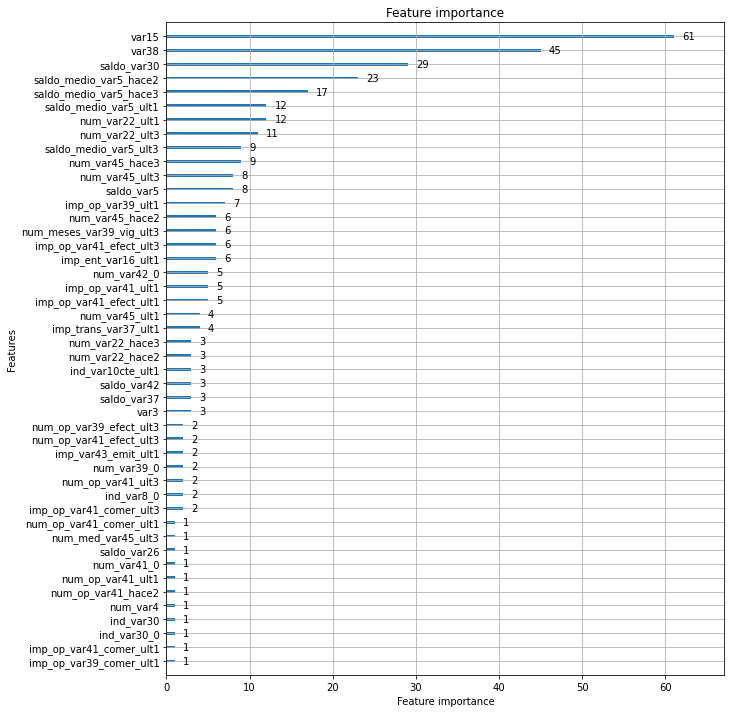

In [16]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_clf,ax=ax)